<a href="https://colab.research.google.com/github/suzuken0/Laboratory_course/blob/master/concat_coco_format_json.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MobiusデータセットからCOCO-jsonへ変換

In [ ]:
import cv2
import numpy as np
import json
from skimage import measure
import os
from google.colab import drive
import matplotlib
from matplotlib import pyplot as plt

%pip install tqdm
from tqdm import tqdm

In [ ]:
!pip install labelme2coco
import labelme2coco

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=0dcf13085b68c264333c85d99e2ca31e104c15995615bd5633c547d8a1ed25c0
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def create_mask(image, color):
    return np.all(image == color, axis=-1)


def apply_mask(image, mask):
    return np.where(mask, 255, 0)


def extract_contours(img, _num_points):
    contours = measure.find_contours(img, 0.5)
    points_list = []

    for contour in contours:
        contour_length = len(contour)

        if contour_length > _num_points:
            step = contour_length // _num_points
            selected_points = [contour[i * step] for i in range(_num_points)]
        else:
            selected_points = contour

        points = [[float(point[1]), float(point[0])] for point in selected_points]
        points_list.append(points)

    return points_list


def create_json(points_list_blue, points_list_blue_green, points_list_all_colors, json_name, img_path, img_data, img_height, img_width):
    data = {
        "version": "5.4.1",
        "flags": {},
        "shapes": [],
        "imagePath": img_path,
        "imageData": img_data,
        "imageHeight": img_height,
        "imageWidth": img_width
    }

    data["shapes"].append({
        "label": "eyelid",
        "points": points_list_all_colors,
        "group_id": None,
        "description": "",
        "shape_type": "polygon",
        "flags": {},
        "mask": None
    })

    data["shapes"].append({
        "label": "iris",
        "points": points_list_blue_green,
        "group_id": None,
        "description": "",
        "shape_type": "polygon",
        "flags": {},
        "mask": None
    })

    data["shapes"].append({
        "label": "pupil",
        "points": points_list_blue,
        "group_id": None,
        "description": "",
        "shape_type": "polygon",
        "flags": {},
        "mask": None
    })

    with open(json_name, 'w') as fw:
        json.dump(data, fw, indent=2)


def main(mask_file, json_name):
    img = cv2.imread(mask_file, cv2.IMREAD_COLOR)
    img_height, img_width = img.shape[:2]

    mask_blue = create_mask(img, [255, 0, 0])
    mask_green = create_mask(img, [0, 255, 0])
    mask_red = create_mask(img, [0, 0, 255])

    mask_blue_green = np.logical_or(mask_blue, mask_green)
    mask_all_colors = np.logical_or(mask_blue_green, mask_red)

    img_blue = apply_mask(img, mask_blue)
    img_blue_green = apply_mask(img, mask_blue_green)
    img_all_colors = apply_mask(img, mask_all_colors)

    points_list_blue = extract_contours(img_blue, num_points)
    points_list_blue_green = extract_contours(img_blue_green, num_points)
    points_list_all_colors = extract_contours(img_all_colors, num_points)

    create_json(points_list_blue, points_list_blue_green, points_list_all_colors, json_name, mask_file, "/9", img_height, img_width)






def process_images(base_dir, output_dir, num_images=10):
    mask_dir = os.path.join(base_dir, "Masks")
    json_dir = os.path.join(base_dir, "json")

    # 画像ファイルの総数を取得（進捗バーの最大値として使用）
    total_images = sum([len(files) for r, d, files in os.walk(mask_dir) if files])

    # tqdmを使って進捗バーを初期化
    with tqdm(total=min(total_images, num_images)) as pbar:
        for folder in os.listdir(mask_dir):
            folder_path = os.path.join(mask_dir, folder)
            if not os.path.isdir(folder_path):
                continue

            output_folder = os.path.join(json_dir, folder)
            os.makedirs(output_folder, exist_ok=True)

            for filename in os.listdir(folder_path):
                if filename.endswith(".png"):
                    mask_file = os.path.join(folder_path, filename)
                    json_name = os.path.join(output_folder, filename.replace(".png", ".json"))
                    main(mask_file, json_name)

                    pbar.update(1)  # 進捗バーを更新
                    if pbar.n >= num_images:
                        return  # 指定された数の画像を処理したら終了


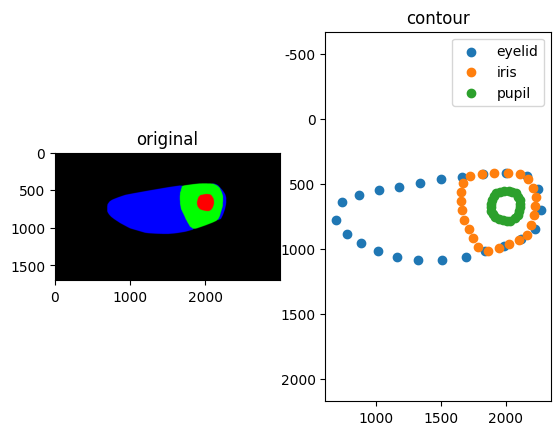

In [ ]:



#マスクされた画像のパスを指定してください。
mask_file = "/content/drive/MyDrive/AI_laboratory_course/YOLACT_Mobius_ocular_dataset/Masks/1/1_3n_Rl_1.png"
json_name = "output.json"

#輪郭点の個数を指定してください。
num_points = 24

if __name__ == '__main__':
    main(mask_file, json_name)




In [ ]:
# 最初の10枚の画像を処理
#process_images("/content/drive/MyDrive/AI_laboratory_course/MOBIUS", "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/json", num_images=10)

# 確認後、すべての画像を処理する場合は以下のように呼び出す
process_images("/content/drive/MyDrive/AI_laboratory_course/MOBIUS", "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/json", num_images=float('inf'))


100%|██████████| 3559/3559 [1:02:06<00:00,  1.05s/it]


In [ ]:
#保存する場合
#os.makedirs('/content/drive/MyDrive/AI_laboratory_course/YOLACT_Mobius_ocular_dataset/json/ex', exist_ok=True)
!cp output.json /content/drive/MyDrive/AI_laboratory_course/YOLACT_Mobius_ocular_dataset/json/ex/

In [ ]:


# JSONファイルのパス
json_file_path = "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/json/1/1_1i_Ll_1.json"

with open(json_file_path, "r") as json_file:
    data = json.load(json_file)

# imagePathの値をファイル名のみに更新
data["imagePath"] = os.path.basename(data["imagePath"])

# JSONファイルに変更を保存
with open(json_file_path, "w") as json_file:
    json.dump(data, json_file, indent=4)


In [ ]:
import os
from tqdm import tqdm

def process_images(base_dir, output_dir, num_images=10):
    mask_dir = os.path.join(base_dir, "Masks")
    json_dir = os.path.join(base_dir, "json")

    # 画像ファイルの総数を取得
    total_images = sum([len(files) for r, d, files in os.walk(mask_dir) if files])

    # tqdmを使って進捗バーを初期化
    with tqdm(total=min(total_images, num_images)) as pbar:
        for folder in os.listdir(mask_dir):
            folder_path = os.path.join(mask_dir, folder)
            if not os.path.isdir(folder_path):
                continue

            output_folder = os.path.join(output_dir, folder)
            os.makedirs(output_folder, exist_ok=True)

            for filename in os.listdir(folder_path):
                if filename.endswith(".png"):
                    mask_file = os.path.join(folder_path, filename)
                    json_name = os.path.join(output_folder, filename.replace(".png", ".json"))

                    # ここで各画像に対する処理を行う
                    main(mask_file, json_name)

                    pbar.update(1)  # 進捗バーを更新
                    if pbar.n >= num_images:
                        return  # 指定された数の画像を処理したら終了

# 基本ディレクトリと出力ディレクトリの設定
base_dir = "/content/drive/MyDrive/AI_laboratory_course/MOBIUS"
output_dir = "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/json"




In [ ]:
# 最初は10枚の画像でテスト
process_images(base_dir, output_dir, num_images=10)

# 問題がなければ全画像に適用
# process_images(base_dir, output_dir, num_images=float('inf'))


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


In [ ]:
%ls

1/   11/  13/  15/  17/  19/  20/  22/  24/  26/  28/  3/   31/  33/  35/  5/  7/  9/
10/  12/  14/  16/  18/  2/   21/  23/  25/  27/  29/  30/  32/  34/  4/   6/  8/


In [ ]:
%cd 1

/content/drive/MyDrive/AI_laboratory_course/MOBIUS/Masks/1


In [ ]:
%cd ../


/content/drive/MyDrive/AI_laboratory_course/MOBIUS


In [ ]:
%cd json

/content/drive/MyDrive/AI_laboratory_course/MOBIUS/json


In [ ]:
%cd 1

/content/drive/MyDrive/AI_laboratory_course/MOBIUS/json/1


In [ ]:
%ls

1_1i_Ll_1.json  1_1n_Rl_1.json  1_2i_Ll_1.json  1_2n_Rl_1.json  1_3i_Ll_1.json  1_3n_Rl_1.json
1_1i_Ll_2.json  1_1n_Rl_2.json  1_2i_Ll_2.json  1_2n_Rl_2.json  1_3i_Ll_2.json  1_3n_Rl_2.json
1_1i_Lr_1.json  1_1n_Rr_1.json  1_2i_Lr_1.json  1_2n_Rr_1.json  1_3i_Lr_1.json  1_3n_Rr_1.json
1_1i_Lr_2.json  1_1n_Rr_2.json  1_2i_Lr_2.json  1_2n_Rr_2.json  1_3i_Lr_2.json  1_3n_Rr_2.json
1_1i_Ls_1.json  1_1n_Rs_1.json  1_2i_Ls_1.json  1_2n_Rs_1.json  1_3i_Ls_1.json  1_3n_Rs_1.json
1_1i_Ls_2.json  1_1n_Rs_2.json  1_2i_Ls_2.json  1_2n_Rs_2.json  1_3i_Ls_2.json  1_3n_Rs_2.json
1_1i_Lu_1.json  1_1n_Ru_1.json  1_2i_Lu_1.json  1_2n_Ru_1.json  1_3i_Lu_1.json  1_3n_Ru_1.json
1_1i_Lu_2.json  1_1n_Ru_2.json  1_2i_Lu_2.json  1_2n_Ru_2.json  1_3i_Lu_2.json  1_3n_Ru_2.json
1_1i_Rl_1.json  1_1p_Ll_1.json  1_2i_Rl_1.json  1_2p_Ll_1.json  1_3i_Rl_1.json  1_3p_Ll_1.json
1_1i_Rl_2.json  1_1p_Ll_2.json  1_2i_Rl_2.json  1_2p_Ll_2.json  1_3i_Rl_2.json  1_3p_Ll_2.json
1_1i_Rr_1.json  1_1p_Lr_1.json  1_2i_Rr_1.json  1_

In [ ]:
import os
from tqdm import tqdm

def process_all_json_files(json_dir, num_images=10):
    # JSONファイルの総数を取得
    total_files = sum([len(files) for r, d, files in os.walk(json_dir) if files])

    # tqdmを使って進捗バーを初期化
    with tqdm(total=min(total_files, num_images)) as pbar:
        for root, dirs, files in os.walk(json_dir):
            for file in files:
                if file.endswith(".json"):
                    json_file_path = os.path.join(root, file)

                    # ここでJSONファイルに対する処理を行う
                    # 例: JSONファイルを読み込み、内容を変更し、上書き保存
                    with open(json_file_path, 'r') as json_file:
                        data = json.load(json_file)

                    # ここにJSONデータを変更するコードを追加

                    with open(json_file_path, 'w') as json_file:
                        json.dump(data, json_file, indent=4)

                    pbar.update(1)  # 進捗バーを更新
                    if pbar.n >= num_images:
                        return  # 指定された数のファイルを処理したら終了

# JSONディレクトリのパス
json_dir = "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/json"

# 最初は10個のファイルでテスト
process_all_json_files(json_dir, num_images=10)

# 問題がなければ、全ファイルに適用
# process_all_json_files(json_dir, num_images=float('inf'))


100%|██████████| 10/10 [00:00<00:00, 64.70it/s]


In [ ]:
# prompt: 上記のコードで書き換えたを実行したファイル10個を教えてください

1_1i_Ll_1.json
1_1i_Rl_1.json
1_1n_Ll_1.json
1_1n_Rl_1.json
1_3i_Ll_1.json
1_3i_Rl_1.json
1_3n_Ll_1.json
1_3n_Rl_1.json
1_4i_Ll_1.json
1_4i_Rl_1.json


In [ ]:
import os
import json
from tqdm import tqdm

def process_all_json_files(json_dir, num_images=10):
    # JSONファイルの総数を取得
    total_files = sum([len(files) for r, d, files in os.walk(json_dir) if files])

    # tqdmを使って進捗バーを初期化
    with tqdm(total=min(total_files, num_images)) as pbar:
        for root, dirs, files in os.walk(json_dir):
            for file in files:
                if file.endswith(".json"):
                    json_file_path = os.path.join(root, file)

                    # JSONファイルを読み込み
                    with open(json_file_path, 'r') as json_file:
                        data = json.load(json_file)

                    # imagePathの値をファイル名のみに更新
                    data["imagePath"] = os.path.basename(data["imagePath"])

                    # JSONファイルに変更を保存
                    with open(json_file_path, 'w') as json_file:
                        json.dump(data, json_file, indent=4)

                    pbar.update(1)  # 進捗バーを更新
                    if pbar.n >= num_images:
                        return  # 指定された数のファイルを処理したら終了

# JSONディレクトリのパス
json_dir = "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/json"

# 最初は10個のファイルでテスト
#process_all_json_files(json_dir, num_images=10)

# 問題がなければ、全ファイルに適用
process_all_json_files(json_dir, num_images=float('inf'))


100%|██████████| 3559/3559 [00:57<00:00, 61.76it/s]


In [ ]:
# prompt: 上記のコードは、"imagePath": "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/Masks/1/1_1i_Ll_2.png"から1_1i_Ll_2.pngを抜き出すコードに変わっていますか？

Yes, the code has been changed to extract "1_1i_Ll_2.png" from the "imagePath": "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/Masks/1/1_1i_Ll_2.png" string.

Here's the modified code:



In [ ]:
!pip install labelme2coco
import labelme2coco

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=8c6975494d0d305625204b9be79436d23d94aa3979550f9b1605afeb630d7fe8
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76


In [ ]:



# set directory that contains labelme annotations and image files
labelme_folder = "/content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/labelme/labelme" #変換ファイルの保存元

# set export dir
export_dir = "/content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/labelme/coco_format" #保存先

# set train split rate
train_split_rate = 0.85 #これを設定することにより、train.jsonとval.jsonに自動的に仕分けてくれる

# convert labelme annotations to coco
labelme2coco.convert(labelme_folder, export_dir, train_split_rate)

In [ ]:
# prompt: jsonフォルダ内のフォルダに入っている全てのファイルをバラバラの状態で一つ一つ、/content/drive/MyDrive/AI_laboratory_course/MOBIUS/json_concatにコピーを作成してください

import os
import shutil

source_dir = "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/json"
target_dir = "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/concat_json"

for folder in os.listdir(source_dir):
    folder_path = os.path.join(source_dir, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            shutil.copy(file_path, target_dir)


In [ ]:
# prompt: 上記のコードで処理を行った、jsonフォルダ内のフォルダを教えて

folders = os.listdir("/content/drive/MyDrive/AI_laboratory_course/MOBIUS/json_concat")
print(folders)


['10_1i_Ru_2.json', '10_1i_Ru_1.json', '10_1i_Lu_1.json', '10_1n_Ll_2.json', '10_1i_Rl_1.json', '10_1i_Rr_1.json', '10_1n_Rl_2.json', '10_1i_Lr_2.json', '10_1n_Rl_1.json', '10_1i_Rs_2.json', '10_1n_Lu_1.json', '10_1i_Rr_2.json', '10_1i_Ll_1.json', '10_1n_Lr_1.json', '10_1n_Ll_1.json', '10_1i_Rl_2.json', '10_1i_Ls_1.json', '10_1i_Lr_1.json', '10_1n_Lu_2.json', '10_1i_Ls_2.json', '10_1i_Lu_2.json', '10_1i_Rs_1.json', '10_1n_Lr_2.json', '10_1i_Ll_2.json', '10_1n_Ls_2.json', '10_1n_Ls_1.json', '10_1n_Rs_1.json', '10_1p_Ls_1.json', '10_1p_Rl_1.json', '10_1p_Rr_2.json', '10_1p_Ls_2.json', '10_1n_Rs_2.json', '10_1p_Rr_1.json', '10_1p_Ll_2.json', '10_1n_Rr_2.json', '10_1n_Ru_1.json', '10_1p_Lu_1.json', '10_1p_Ru_2.json', '10_1p_Ru_1.json', '10_1p_Lr_1.json', '10_1p_Rs_2.json', '10_1p_Lr_2.json', '10_1p_Rl_2.json', '10_1n_Ru_2.json', '10_1n_Rr_1.json', '10_1p_Lu_2.json', '10_1p_Rs_1.json', '10_1p_Ll_1.json', '1_1i_Rl_1.json', '1_1i_Lr_2.json', '1_1n_Ll_1.json', '1_1i_Lu_2.json', '1_1i_Lu_1.json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install labelme2coco
import labelme2coco

# LabelMeアノテーションと画像ファイルが含まれるディレクトリを設定
labelme_folder = "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/concat_json"

# エクスポートするディレクトリを設定
export_dir = "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/coco_format"

# トレーニングデータの分割率を設定
train_split_rate = 0.85

# LabelMeアノテーションをCOCO形式に変換
labelme2coco.convert(labelme_folder, export_dir, train_split_rate)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
There are 3559 listed files in folder concat_json.


Converting labelme annotations to COCO format: 100%|██████████| 3559/3559 [01:55<00:00, 30.88it/s] 


In [ ]:
import json
import os

def convert_points_format(json_file_path):
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    for shape in data['shapes']:
        # ネストを1レベル減らします
        shape['points'] = [point[0] for point in shape['points']]

    with open(json_file_path, 'w') as file:
        json.dump(data, file, indent=4)

# JSONファイルが保存されているディレクトリへのパス
json_dir = "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/json_concat"

# ディレクトリ内の全てのJSONファイルに対して上記の関数を適用
for root, dirs, files in os.walk(json_dir):
    for file in files:
        if file.endswith(".json"):
            json_file_path = os.path.join(root, file)
            convert_points_format(json_file_path)


In [ ]:
import json
import os
from tqdm import tqdm

def convert_points_format(json_file_path):
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    for shape in data['shapes']:
        # ネストを1レベル減らします
        shape['points'] = [point[0] for point in shape['points']]

    with open(json_file_path, 'w') as file:
        json.dump(data, file, indent=4)

# JSONファイルが保存されているディレクトリへのパス
json_dir = "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/json_concat"

# JSONファイルの総数を取得
total_files = sum([len(files) for r, d, files in os.walk(json_dir) if files])

# ディレクトリ内の全てのJSONファイルに対して上記の関数を適用（tqdmを使用）
with tqdm(total=total_files, desc="Converting JSON files") as pbar:
    for root, dirs, files in os.walk(json_dir):
        for file in files:
            if file.endswith(".json"):
                json_file_path = os.path.join(root, file)
                convert_points_format(json_file_path)
                pbar.update(1)


Converting JSON files: 100%|██████████| 3559/3559 [03:36<00:00, 16.45it/s]


ネストを減らすコード

In [ ]:
import json
import os
from tqdm import tqdm

def convert_points_format(json_file_path):
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    for shape in data['shapes']:
        # ネストを1レベル減らす
        shape['points'] = [p for sublist in shape['points'] for p in sublist]

    with open(json_file_path, 'w') as file:
        json.dump(data, file, indent=4)

# JSONファイルが保存されているディレクトリへのパス
json_dir = "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/concat_json"

# JSONファイルの総数を取得
total_files = sum([len(files) for r, d, files in os.walk(json_dir) if files])

# ディレクトリ内の全てのJSONファイルに対して上記の関数を適用（tqdmを使用）
with tqdm(total=total_files, desc="Converting JSON files") as pbar:
    for root, dirs, files in os.walk(json_dir):
        for file in files:
            if file.endswith(".json"):
                json_file_path = os.path.join(root, file)
                convert_points_format(json_file_path)
                pbar.update(1)


Converting JSON files: 100%|██████████| 3559/3559 [01:54<00:00, 31.14it/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install labelme2coco
import labelme2coco

# LabelMeアノテーションと画像ファイルが含まれるディレクトリを設定
labelme_folder = "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/ex_json"

# エクスポートするディレクトリを設定
export_dir = "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/coco_format"

# トレーニングデータの分割率を設定
train_split_rate = 0.85

# LabelMeアノテーションをCOCO形式に変換
labelme2coco.convert(labelme_folder, export_dir, train_split_rate)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
There are 10 listed files in folder ex_json.


Converting labelme annotations to COCO format: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


In [ ]:


# LabelMeアノテーションと画像ファイルが含まれるディレクトリを設定
labelme_folder = "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/concat_json"

# エクスポートするディレクトリを設定
export_dir = "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/coco_format"

# トレーニングデータの分割率を設定
train_split_rate = 0.85

# フォルダ内のファイルリストを取得
file_list = os.listdir(labelme_folder)

# 進捗バーを表示してLabelMeアノテーションをCOCO形式に変換
for file_name in tqdm(file_list, desc="Converting to COCO"):
    if file_name.endswith('.json'):
        json_file_path = os.path.join(labelme_folder, file_name)
        labelme2coco.convert(json_file_path, export_dir, train_split_rate)

print("Conversion complete.")
